In [1]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
from collections import defaultdict
#import gensim.utils.lemmatize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the data using Pandas
data = pd.read_csv('globe_data/bostonglobe2014.csv')

In [3]:
# strip the text of unnecessary whitespaces and removing special characters
def custom_standardization(data):

    spec_chars = ["!",'"',"#","%","&","'","(",")", "*","+",",",
                  "-",".","/",":",";","<", "=",">","?","@","[",
                  "\\","]","^","_", "`","{","|","}","~","–", 
                  "\xc2", "\xa0", "\x80", "\x9c", "\x99", "\x94", 
                  "\xad", "\xe2", "\x9d", "\n"]

    for char in spec_chars:
        data['text'] = data['text'].str.strip()
        data['text'] = data['text'].str.replace(char, ' ')
        
    return data

# do stemming before training
# compare differences between word vectors for 'black' as well as 'white' to better identify biased representations
# think about word frequency, so that context isn't specific, but rather, general
# increase data point size for visualizations

# instead of keywords, use sub-neighborhood names

# cluster similar words
# visualize those with a meta word that's representative
# either use average word vectors or minimizing function to get representative word

In [4]:
df = custom_standardization(data)

In [5]:
# turn DataFrame into a list of lists of tokens
documents = []
mentions = {'hyde_park': 0, 'beacon_hill': 0, 'south_boston': 0, 'jamaica_plain': 0, 'east_boston': 0,
           'south_end': 0, 'back_bay': 0, 'north_end': 0, 'west_roxbury': 0, 'mission_hill': 0,
           'harbor_islands': 0, 'west_end': 0, 'south_boston_waterfront': 0, 'longwood_medical_area': 0,
           'dorchester': 0, 'roxbury': 0, 'downtown': 0, 'fenway': 0, 'mattapan': 0, 'brighton': 0,
           'charlestown': 0, 'roslindale': 0, 'allston': 0}
for row in df.values:
    [row] = row
    temp = row.lower().split()
    length = len(temp) - 1
    for i in range(length):
        if temp[i] == 'hyde' and temp[i + 1] == 'park':
            temp[i] = 'hyde_park'
            temp.pop(i + 1)
            length -= 1
            mentions['hyde_park'] += 1
        elif temp[i] == 'dorchester':
            mentions['dorchester'] += 1
        elif temp[i] == 'roxbury':
            mentions['roxbury'] += 1
        elif temp[i] == 'downtown':
            mentions['downtown'] += 1
        elif temp[i] == 'fenway':
            mentions['fenway'] += 1
        elif temp[i] == 'mattapan':
            mentions['mattapan'] += 1
        elif temp[i] == 'brighton':
            mentions['brighton'] += 1
        elif temp[i] == 'charlestown':
            mentions['charlestown'] += 1
        elif temp[i] == 'roslindale':
            mentions['roslindale'] += 1
        elif temp[i] == 'allston':
            mentions['allston'] += 1
        elif temp[i] == 'beacon' and temp[i + 1] == 'hill':
            temp[i] = 'beacon_hill'
            temp.pop(i + 1)
            length -= 1
            mentions['beacon_hill'] += 1
        elif temp[i] == 'south' and temp[i + 1] == 'boston':
            temp[i] = 'south_boston'
            temp.pop(i + 1)
            length -= 1
            mentions['south_boston'] += 1
        elif temp[i] == 'jamaica' and temp[i + 1] == 'plain':
            temp[i] = 'jamaica_plain'
            temp.pop(i + 1)
            length -= 1
            mentions['jamaica_plain'] += 1
        elif temp[i] == 'east' and temp[i + 1] == 'boston':
            temp[i] = 'east_boston'
            temp.pop(i + 1)
            length -= 1
            mentions['east_boston'] += 1
        elif temp[i] == 'south' and temp[i + 1] == 'end':
            temp[i] = 'south_end'
            temp.pop(i + 1)
            length -= 1
            mentions['south_end'] += 1
        elif temp[i] == 'back' and temp[i + 1] == 'bay':
            temp[i] = 'back_bay'
            temp.pop(i + 1)
            length -= 1
            mentions['back_bay'] += 1
        elif temp[i] == 'north' and temp[i + 1] == 'end':
            temp[i] = 'north_end'
            temp.pop(i + 1)
            length -= 1
            mentions['north_end'] += 1
        elif temp[i] == 'west' and temp[i + 1] == 'roxbury':
            temp[i] = 'west_roxbury'
            temp.pop(i + 1)
            length -= 1
            mentions['west_roxbury'] += 1
        elif temp[i] == 'mission' and temp[i + 1] == 'hill':
            temp[i] = 'mission_hill'
            temp.pop(i + 1)
            length -= 1
            mentions['mission_hill'] += 1
        elif temp[i] == 'harbor' and temp[i + 1] == 'islands':
            temp[i] = 'harbor_islands'
            temp.pop(i + 1)
            length -= 1
            mentions['harbor_islands'] += 1
        elif temp[i] == 'west' and temp[i + 1] == 'end':
            temp[i] = 'west_end'
            temp.pop(i + 1)
            length -= 1
            mentions['west_end'] += 1
        elif i > 0 and temp[i - 1] == 'south' and temp[i] == 'boston' and temp[i + 1] == 'waterfront':
            temp[i - 1] = 'south_boston_waterfront'
            temp.pop(i + 1)
            temp.pop(i)
            length -= 2
            mentions['south_boston_waterfront'] += 1
        elif i > 0 and temp[i - 1] == 'longwood' and temp[i] == 'medical' and temp[i + 1] == 'area':
            temp[i - 1] = 'longwood_medical_area'
            temp.pop(i + 1)
            temp.pop(i)
            length -= 1
            mentions['longwood_medical_area'] += 1
        elif i >= length - 3:
            break
    documents.append(temp)
    #print(len(documents))

In [6]:
# create Word2Vec model
# the skip-grams method is used here, with a window of 10
model = gensim.models.Word2Vec(window=10, min_count=2, sg=1, workers=10)
model.build_vocab(documents)  # prepare the model vocabulary

In [7]:
# train model on available data
# I use 5 epochs since that's standard
model.train(corpus_iterable=documents, total_examples=len(documents), epochs=5)

(7126053, 9143345)

In [8]:
# words of interest
# some words are missing in the final 'keywords' list since those do not occur in any of the articles

#black_keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 
#                  'neighborhood', 'child', 'children', 'kid', 'youth', 'business', 'company']

#black_ethnicities = ['black', 'cape verdean', 'afro latino', 'afro latina', 'haitian', 'african american', 
#                     'african-american', 'caribbean', 'jamaican', 'dominican', 'west indian']

black_neighborhoods = ['dorchester', 'roxbury', 'mattapan', 'hyde_park']
white_neighborhoods = ['fenway', 'beacon_hill', 'downtown', 'south_boston', 'east_boston', 'back_bay', 'jamaica_plain',
                      'south_end', 'charlestown', 'brighton', 'allston', 'west_end', 'roslindale', 'north_end',
                      'mission_hill', 
                       #'south_boston_waterfront', 
                       'harbor_islands', 'longwood_medical_area']

keywords = black_neighborhoods + white_neighborhoods



# extract vector for neighborhood
# vector for corresponding majority ethnicity
# add those together
# look for words that are close to that sum vector
# repeat for other ethnicities
# what differences do we get in terms of results for last week vs results for this week



In [9]:
# finding similar words and creating a csv file
# check if similar words list includes any keywords
# if so, remove those keywords from the similar words list

def compute_similar_words(model,source_word, topn=25):
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word, topn=topn)
        length_top = len(top_words)
        i = 0
        while i < length_top:
            #print('i=' + str(i) + ' len(top_words)=' + str(len(top_words)) + 'length_top=' + str(length_top))
            if i >= length_top - 1:
                break
            elif top_words[i][0] in mentions.keys():
                top_words.pop(i)
                length_top -= 1
            else:
                i += 1
        similar_words.extend([val[0] for val in top_words[:5]])
    except KeyError as err:
        print(err.args)
    return similar_words    

def compute_similar_words_and_representative_for_all_tasks(model, topn=25):
    columns = ['word' + str(i - 1) for i in range(1, 7)]
    df = pd.DataFrame(data=None, columns=columns)
    reps = defaultdict()
    for source_word in keywords:
        similar_words = compute_similar_words(model, source_word, topn)
        
        df.loc[len(df)] = similar_words
        sum_vec = (model.wv[similar_words[0]]).copy()
        for i in range(1, 5):
            temp = model.wv[similar_words[i]]
            sum_vec += temp.copy()
        rep_vec = sum_vec / 5
        reps[source_word] = model.wv.most_similar(positive=[rep_vec], topn=1)
    for i in range(1, len(similar_words)):
        sec_similar_words = compute_similar_words(model, similar_words[i], topn)
        df.loc[len(df)] = sec_similar_words
    df.to_csv('similar_words_task/neighborhood_filtered_similar_words/2014_findings.csv')
    rep_ser = pd.Series(reps)
    rep_ser.to_csv('similar_words_task/representative_words/2014_neighborhoods.csv')
    
words = compute_similar_words_and_representative_for_all_tasks(model)

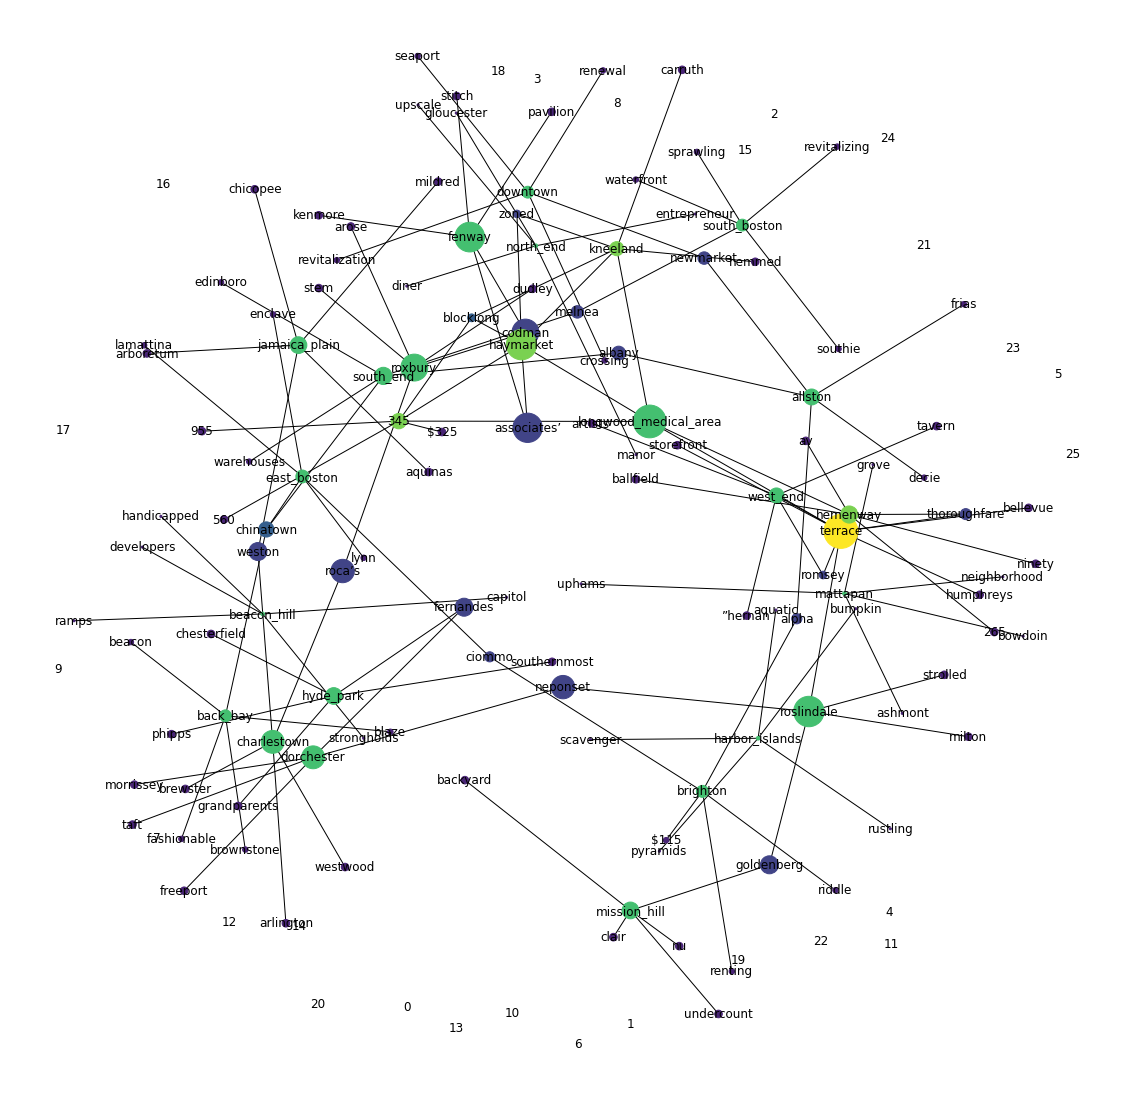

In [10]:
# create word cloud from csv file created using Word2Vec
# code shamelessly copied from Hong

import networkx as nx
from random import randint 
from itertools import count

words = pd.read_csv('similar_words_task/neighborhood_filtered_similar_words/2014_findings.csv')

G = nx.Graph()
j = 1
for i, row in words.iterrows():
    for j in range(1, len(row)):
        G.add_node(i, label=row[j])
    for j in range(1, len(row)):
        G.add_edge(row[1], row[j])
remove = [node for node, degree in dict(G.degree()).items() if degree > 2]

pos = nx.spring_layout(G, k=0.3)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20, 20))
nx.draw_networkx(G, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')
plt.savefig('word_clouds_img/neighborhood_filtered_word_clouds/2014_cloud.png')
plt.show()

In [11]:
freq = pd.Series(mentions)
freq = freq.sort_values(ascending=False)
freq

dorchester                 1137
roxbury                     650
south_boston                313
hyde_park                   291
mattapan                    272
downtown                    253
west_roxbury                189
back_bay                    171
jamaica_plain               157
mission_hill                152
south_end                   151
beacon_hill                 150
brighton                    142
roslindale                  137
fenway                      126
allston                     123
east_boston                 100
charlestown                  86
north_end                    40
west_end                     26
longwood_medical_area         5
harbor_islands                4
south_boston_waterfront       0
dtype: int64

In [12]:
freq.to_csv('similar_words_task/keyword_frequencies/2014_neighborhood_frequencies.csv')